<table style="width:99%">
<tr>    
<td style="text-align: center">
<h1>Lab 04: Assignment</h1>
<h2>Arkadiusz Paterak</h2>
</td>
</tr>
</table>

# Introduction

This report presents a numerical solution to an advection-diffusion problem using the upwind scheme and compares it with the analytical solution.

The solution might model a physical problems like e.g. spread of pollutant in a river. The pollutant is transported by the flow of the river, but also by diffusion in the water. We can consider the river as one dimensional, what fits the presented solution.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot, show_anim

I consider a Gaussian distribution of the signal as the initial state:

$$\psi(x, 0) = a \cdot \exp\left(-\frac{(x - x_0)^2}{2\sigma^2}\right).$$

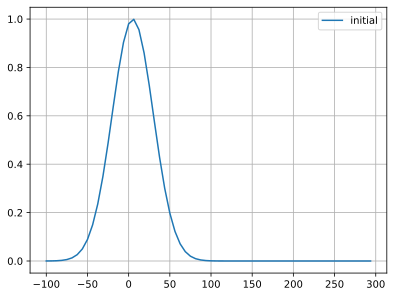

In [5]:
class PsiInitial:
    def __init__(self, x0=5, a=1, sigma=25):
        self.x_0 = x0
        self.a = a
        self.sigma = sigma

    def __call__(self, x):
        return self.a * np.exp(-(x - self.x_0)**2 / (2 * self.sigma**2))

psi_0 = PsiInitial()
nx = 64
x_min, x_max = -100, 300
x, dx = np.linspace(x_min, x_max, nx, endpoint=False, retstep=True)

plt.plot(x, psi_0(x), label='initial')
plt.legend()
plt.grid()
show_plot("initial.pdf")

# Analytical solution

To obtain an analytical solution describing change of the signal due to both advection and diffusion, these two effects need to be combined.

Transport of $\psi$ (some signal) due to advection by $u$ (carrier velocity field) can be modelled with **the advection equation**:

$$ \partial_t \psi + \partial_x \left(u \psi\right) = 0.$$

For the special case of $\partial_x u=0$, the analytical solution is expressed as:

$$ \psi(x, t)=\psi_0(x - ut),$$

where $\psi_0(x)=\psi(x, 0)$, or with an explicit initial state in the case of the Gaussian distribution of the signal:

$$\psi(x, t) = \psi_0(x - ut) = a \cdot \exp\left(-\frac{((x - ut) - x_0)^2}{2 \sigma^2}\right).$$

Transport of $\psi$ due to diffusion with a constant coefficient $D$ can be modelled with **the diffusion equation**:
$$ \partial_t \psi - D \partial^2_x \psi= 0.$$

I implemented the analytical solution for **advection combined with diffusion** based on this equation:

$$\psi(x, t) = a \cdot \frac{\sigma}{\sqrt{\sigma^2 + 2Dt}} \cdot \exp\left(-\frac{(x - (x_0 + ut))^2}{2(\sigma^2 + 2Dt)}\right).$$

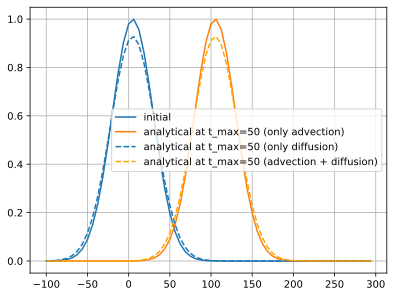

In [6]:
def analytical_solution(psi_0, x, t, *, u=0, D=0):
    """
    It can model just advection with u=0, and just diffusion with D=0.
    """
    x_0 = psi_0.x_0
    a = psi_0.a
    sigma = psi_0.sigma
    return a * (sigma / np.sqrt(sigma**2 + 2*D*t)) * np.exp(-(x - (x_0 + u*t))**2 / (2 * (sigma**2 + 2*D*t)))

t_max = 50
u = 2
D = 1

plt.plot(x, psi_0(x), label='initial')
plt.plot(x, analytical_solution(psi_0, x, t=t_max, u=u), label=f'analytical at {t_max=} (only advection)', color='tab:orange')
plt.plot(x, analytical_solution(psi_0, x, t=t_max, D=D), label=f'analytical at {t_max=} (only diffusion)', color='tab:blue', linestyle='--')
plt.plot(x, analytical_solution(psi_0, x, t=t_max, u=u, D=D), label=f'analytical at {t_max=} (advection + diffusion)', color='orange', linestyle='--')
plt.legend()
plt.grid()
show_plot("analytical.pdf")

# Numerical solution

In [10]:
def F(psi_L, psi_R, C):
    return 0.5 * (C + np.abs(C)) * psi_L + \
           0.5 * (C - np.abs(C)) * psi_R

class Shift:
    def __init__(self, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, s: slice) -> slice:
        return slice(s.start + self.add, s.stop + self.add)

    def __rsub__(self, s: slice) -> slice:
        return slice(s.start - self.sub, s.stop - self.sub)

In [29]:
def numerical_solution(
    psi_0,
    x,
    *,
    C_advection,
    dx,
    dt,
    nx,
    nt,
    D=0,
):
    def advection_step(psi, C):
        psi[i] = psi[i] - (
            F(psi[i], psi[i + one], C) - F(psi[i - one], psi[i], C)
        )

    def diffusion_step(psi, C):
        C[im - half] = -2 * D * dt / dx**2 * (psi[im] - psi[im - one]) / (psi[im] + psi[im - one])

        psi[i] = psi[i] - (
            F(psi[i], psi[i + one], C[i + half]) - F(psi[i - one], psi[i], C[i - half])
        )

    one = Shift(add=1, sub=1)
    half = Shift(add=0, sub=1)
    i = slice(1, nx-2)
    im = slice(1, nx-1)

    psi = psi_0(x)

    C_diffusion = np.zeros(len(psi) - 1)

    output = [psi.copy()]
    for _ in range(nt):
        advection_step(psi, C=C_advection)
        diffusion_step(psi, C=C_diffusion)

        output += [psi.copy()]

    return output

# Comparison of methods

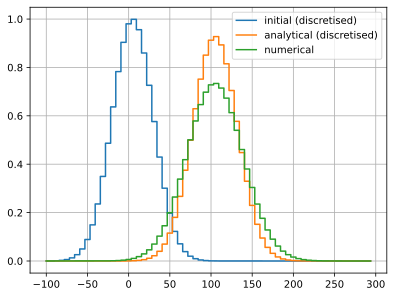

In [38]:
psi_0 = PsiInitial()
nx = 64
x_min, x_max = -100, 300
x, dx = np.linspace(x_min, x_max, nx, endpoint=False, retstep=True)

t_max = 50
u = 2
D = 1

nt = 50
dt = t_max / nt

C_advection = u * dt / dx

psi = numerical_solution(psi_0=psi_0, x=x, C_advection=C_advection, dx=dx, dt=dt, nx=nx, nt=nt, D=D)

plt.step(x, psi_0(x), label='initial (discretised)', where='mid')
plt.step(x, analytical_solution(psi_0, x, t_max, u=u, D=D), label='analytical (discretised)', where='mid')
plt.step(x, psi[-1], label=f'numerical', where='mid')
plt.legend()
plt.grid()
show_plot()

In [37]:
# def plot(step):
#     fig = plt.figure()
#     plt.step(x, psi_0(x), label='initial (discretised)', where='mid')
#     plt.step(x, analytical_solution(psi_0, x, t=step*dt, u=u, D=D), label='analytical (discretised)', where='mid')
#     plt.step(x, psi[step], label=f'numerical', where='mid')
#     plt.legend()
#     plt.grid()
#     return fig

# show_anim(plot, range(0, nt, 2))

In [39]:
def rmse(numerical, analytical):
    return np.sqrt(np.mean((numerical - analytical)**2))

In [40]:
psi_numerical = numerical_solution(psi_0=psi_0, x=x, C_advection=C_advection, dx=dx, dt=dt, nx=nx, nt=nt, D=D)

psi_analytical = analytical_solution(psi_0, x, t_max, u=u, D=D)

print(f"RMSE = {rmse(psi_numerical, psi_analytical)}")

RMSE = 0.32240932643696196


# Conclusions

There is visible difference between the analytical and numerical solutions. With the spatial and temporal resolution that I used, the Root Mean Squared Error has a value of around 0.32. The results of the numerical solution could be improved e.g. using the MPDATA algorithm from the Laboratory classes 5.